# Characterization of Raw Data from NHL API
___

In [65]:
import os
import findspark
import pyspark
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# start spark
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/jdk1.8.0_231.jdk/Contents/Home/"
os.environ["JRE_HOME"] = "/Library/Java/JavaVirtualMachines/jdk1.8.0_231.jdk/Contents/Home/"
findspark.init("/usr/local/Cellar/apache-spark/2.4.5/libexec/")
spark = pyspark.sql\
        .SparkSession\
        .builder\
        .appName('hockey')\
        .config('spark.jars', '/Users/tanyatang/Documents/Code/resources/postgresql/postgresql-42.2.12.jar')\
        .getOrCreate()

In [55]:
# get game info
games = spark.read.jdbc(url='jdbc:postgresql://localhost/50_in_07',
                        table='game',
                        properties={'user': 'tanyatang',
                                    'password': '',
                                    'driver': 'org.postgresql.Driver'})
games.registerTempTable('games')
games.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- season: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- date_time: date (nullable = true)
 |-- date_time_GMT: timestamp (nullable = true)
 |-- away_team_id: integer (nullable = true)
 |-- home_team_id: integer (nullable = true)
 |-- away_goals: integer (nullable = true)
 |-- home_goals: integer (nullable = true)
 |-- outcome: string (nullable = true)
 |-- home_rink_side_start: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- venue_link: string (nullable = true)
 |-- venue_time_zone_id: string (nullable = true)
 |-- venue_time_zone_offset: integer (nullable = true)
 |-- venue_time_zone_tz: string (nullable = true)



In [147]:
# get team info
games = spark.read.jdbc(url='jdbc:postgresql://localhost/50_in_07',
                        table='team',
                        properties={'user': 'tanyatang',
                                    'password': '',
                                    'driver': 'org.postgresql.Driver'})
games.registerTempTable('teams')
games.printSchema()

root
 |-- team_id: integer (nullable = true)
 |-- franchise_id: integer (nullable = true)
 |-- short_name: string (nullable = true)
 |-- team_name: string (nullable = true)
 |-- abbreviation: string (nullable = true)
 |-- link: string (nullable = true)



We have imported the game and team tables from our database. The game table contains information about every game played from the 2010-2011 season to the 2018-2019 season. The team table contains information about all active teams from the 2010-2011 season to the 2018-2019 season. First, let us look at the distribution of winning games across teams and seasons, categorized by being home or away. 

### Comparison of Number of Games Won
___

In [87]:
games_won = spark.sql("""
SELECT a.team, a.season, a.game_count AS home, b.game_count AS away
FROM
(SELECT COUNT(1) AS game_count, home_team_id AS team, season
FROM games
WHERE outcome = 'home win SO'
OR outcome = 'home win OT'
OR outcome = 'home win REG'
GROUP BY home_team_id, season) AS a
FULL OUTER JOIN
(SELECT COUNT(1) AS game_count, away_team_id AS team, season
FROM games
WHERE outcome = 'away win SO'
OR outcome = 'away win OT'
OR outcome = 'away win REG'
GROUP BY away_team_id, season) AS b
ON a.team = b.team
AND a.season = b.season
ORDER BY a.team, a.season
""")
games_won.show(10)

+----+--------+----+----+
|team|  season|home|away|
+----+--------+----+----+
|   1|20102011|  22|  16|
|   1|20112012|  31|  31|
|   1|20122013|  13|   6|
|   1|20132014|  21|  14|
|   1|20142015|  19|  13|
|   1|20152016|  19|  19|
|   1|20162017|  16|  12|
|   1|20172018|  24|  21|
|   1|20182019|  20|  11|
|   2|20102011|  17|  13|
+----+--------+----+----+
only showing top 10 rows



The preceding query counts all winning home and away games and groups the counts by team and season. There is currently no differentiation between different types of wins, i.e. shootout vs overtime vs regular. 

In [130]:
seasons = {20102011: 1,
           20112012: 2,
           20122013: 3,
           20132014: 4,
           20142015: 5,
           20152016: 6,
           20162017: 7,
           20172018: 8,
           20182019: 9}

There are too many teams to plot in one graph, so we will split the results into three graphs. Each graph will show the split between home and away games won for each team. There are five unique teams, the ATL and PHX teams no longer exist so their data stops at 2011 and 2014, respectively. On the other hand, WPG, ARI, and VGK are new teams introduced after 2010, so their data starts at 2011, 2014, and 2017, respectively. 

*Note: the 2012-2013 season was a shortened season due to labour disputes so only 48 games were played in comparison to the usual 82 game-season.*

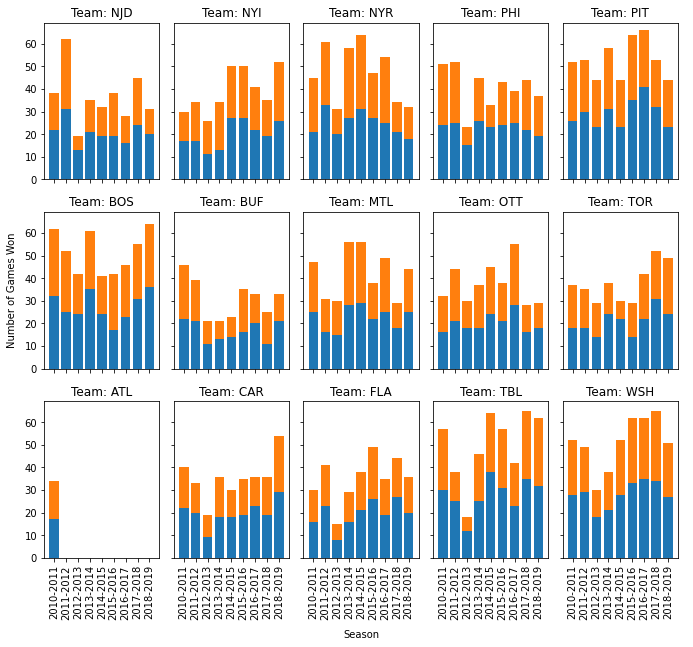

In [142]:
# compare how many games were won at home and away per team per season for teams 1 to 15
fig, ax = plt.subplots(3, 5, figsize=(10, 10), sharex=True, sharey=True)
for i in range(3):
    for j in range(5):
        team = i * 5 + j + 1
        team_name = teams.filter(teams['team_id'] == team).select('abbreviation').collect()[0].abbreviation
        games_won_per_team = games_won.filter(games_won['team'] == team)
        x = list(map(lambda x: x.season,
                 games_won_per_team.select('season').collect()))
        x_vals = np.arange(seasons[x[0]] - 1, seasons[x[len(x) - 1]])
        home_wins = list(map(lambda x: x.home,
                             games_won_per_team.select('home').collect()))
        away_wins = list(map(lambda x: x.away,
                             games_won_per_team.select('away').collect()))
        ax[i][j].bar(x_vals,
                     home_wins)
        ax[i][j].bar(x_vals,
                     away_wins,
                     bottom=home_wins)
        ax[i][j].bar(np.arange(0, 9), [0] * 9)
        ax[i][j].set_title(f'Team: {team_name}')
        ax[i][j].set_xticks(np.arange(0, 9))
        ax[i][j].set_xticklabels(['2010-2011', '2011-2012',
                                  '2012-2013', '2013-2014',
                                  '2014-2015', '2015-2016',
                                  '2016-2017', '2017-2018',
                                  '2018-2019'], 
                                 rotation='vertical')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none',
                top=False,
                bottom=False,
                left=False,
                right=False)
plt.xlabel('Season', labelpad=55)
plt.ylabel('Number of Games Won')
fig.tight_layout()
plt.show()

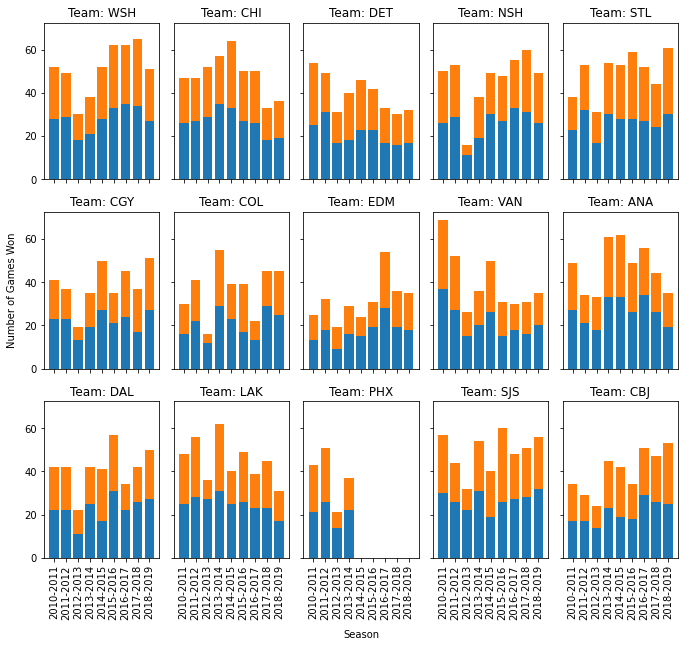

In [143]:
# compare how many games were won at home and away per team per season for teams 16 to 30
fig, ax = plt.subplots(3, 5, figsize=(10, 10), sharex=True, sharey=True)
for i in range(3):
    for j in range(5):
        team = i * 5 + j + 15
        team_name = teams.filter(teams['team_id'] == team).select('abbreviation').collect()[0].abbreviation
        games_won_per_team = games_won.filter(games_won['team'] == team)
        x = list(map(lambda x: x.season,
                 games_won_per_team.select('season').collect()))
        x_vals = np.arange(seasons[x[0]] - 1, seasons[x[len(x) - 1]])
        home_wins = list(map(lambda x: x.home,
                             games_won_per_team.select('home').collect()))
        away_wins = list(map(lambda x: x.away,
                             games_won_per_team.select('away').collect()))
        ax[i][j].bar(x_vals,
                     home_wins)
        ax[i][j].bar(x_vals,
                     away_wins,
                     bottom=home_wins)
        ax[i][j].bar(np.arange(0, 9), [0] * 9)
        ax[i][j].set_title(f'Team: {team_name}')
        ax[i][j].set_xticks(np.arange(0, 9))
        ax[i][j].set_xticklabels(['2010-2011', '2011-2012',
                                  '2012-2013', '2013-2014',
                                  '2014-2015', '2015-2016',
                                  '2016-2017', '2017-2018',
                                  '2018-2019'], 
                                 rotation='vertical')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none',
                top=False,
                bottom=False,
                left=False,
                right=False)
plt.xlabel('Season', labelpad=55)
plt.ylabel('Number of Games Won')
fig.tight_layout()
plt.show()

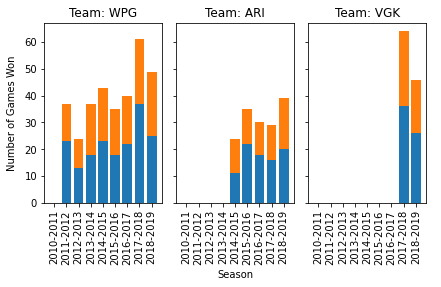

In [146]:
# compare how many games were won at home and away per team per season for teams 52 to 54
fig, ax = plt.subplots(1, 3, figsize=(6.5, 5), sharex=True, sharey=True)
for i in range(3):
    team = 52 + i
    team_name = teams.filter(teams['team_id'] == team).select('abbreviation').collect()[0].abbreviation
    games_won_per_team = games_won.filter(games_won['team'] == team)
    x = list(map(lambda x: x.season,
                 games_won_per_team.select('season').collect()))
    x_vals = np.arange(seasons[x[0]] - 1, seasons[x[len(x) - 1]])
    home_wins = list(map(lambda x: x.home,
                         games_won_per_team.select('home').collect()))
    away_wins = list(map(lambda x: x.away,
                         games_won_per_team.select('away').collect()))
    ax[i].bar(x_vals,
              home_wins)
    ax[i].bar(x_vals,
              away_wins,
              bottom=home_wins)
    ax[i].bar(np.arange(0, 9), [0] * 9)
    ax[i].set_title(f'Team: {team_name}')
    ax[i].set_xticks(np.arange(0, 9))
    ax[i].set_xticklabels(['2010-2011', '2011-2012',
                           '2012-2013', '2013-2014',
                           '2014-2015', '2015-2016',
                           '2016-2017', '2017-2018',
                           '2018-2019'],
                          rotation='vertical')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none',
                top=False,
                bottom=False,
                left=False,
                right=False)
plt.xlabel('Season', labelpad=50)
plt.ylabel('Number of Games Won')
fig.tight_layout()
plt.show()